<a href="https://colab.research.google.com/github/pnabilah/SBP_2025/blob/main/ZSA_Cessna_SystemIden_withpytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [34]:
# Preprocessing Imports
import torch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
# Model Imports
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
if torch.cuda.is_available():       # Should be True
  print(torch.cuda.get_device_name(0))   # Name of the GPU (e.g., Tesla T4)
else:
  print("cpu")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cpu


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# System Identification

## Phase 1

### Load data

In [26]:
# Load data from csv
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/SBP, MML/Dataset/cessna_pitch_altitude.csv')
df.columns = ['x', 't']
print(df)

             x         t
0      1.49593  40.52764
1      1.33864  40.59549
2      1.21016  40.63076
3      1.09080  40.65407
4      0.99866  40.66761
...        ...       ...
33613  3.68583  33.79496
33614  3.50730  33.75129
33615  3.32268  33.70770
33616  3.15426  33.66908
33617  2.98599  33.63131

[33618 rows x 2 columns]


#### EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33618 entries, 0 to 33617
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       33618 non-null  float64
 1   t       33618 non-null  float64
dtypes: float64(2)
memory usage: 525.4 KB


In [6]:
df.describe()

,x,t
count,33618.000000,33618.000000
mean,2.230197,433.542011
std,21.321148,243.101796
min,-54.464500,32.510630
25%,-12.232318,280.613587
50%,0.805050,424.547895
75%,16.586717,624.847413
max,61.598320,933.995730


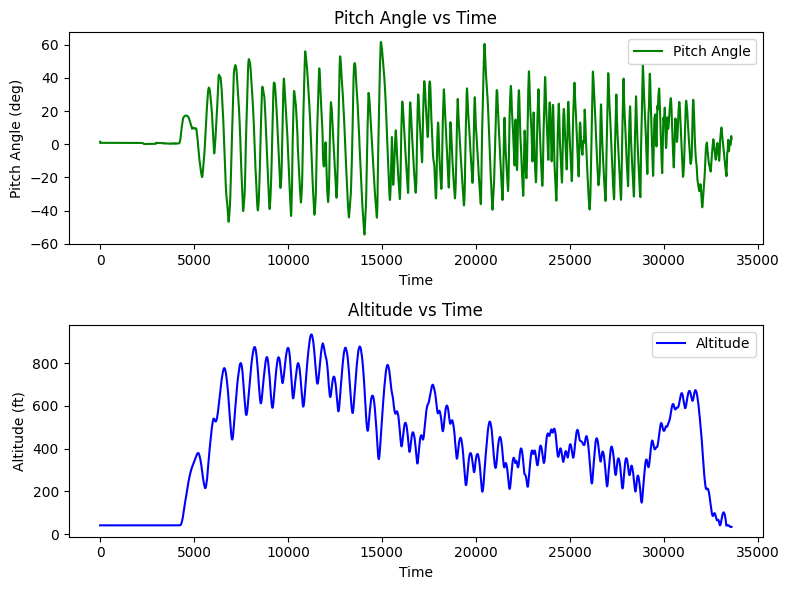

In [7]:
# visualize the data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
# pitch_deg - time plot
ax1.plot(df['x'], label='Pitch Angle', color='green')
ax1.set_xlabel('Time')
ax1.set_ylabel('Pitch Angle (deg)')
ax1.set_title('Pitch Angle vs Time')
ax1.legend()

# altitude_ft - time plot
ax2.plot(df['t'], label='Altitude', color='blue')
ax2.set_xlabel('Time')
ax2.set_ylabel('Altitude (ft)')
ax2.set_title('Altitude vs Time')
ax2.legend()

plt.tight_layout()
plt.show()

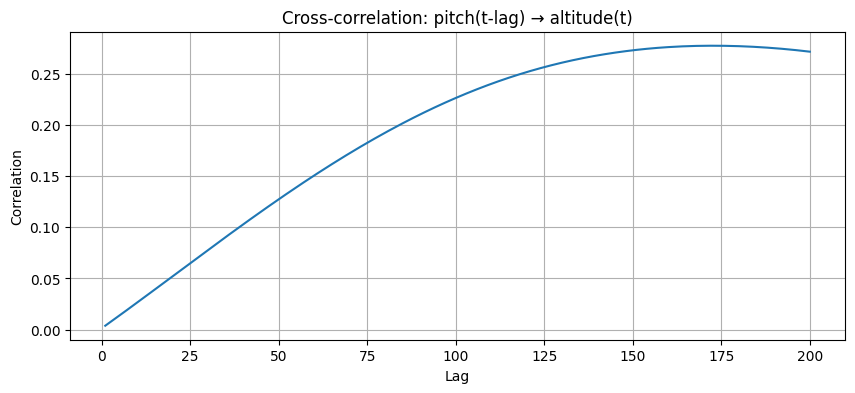

In [10]:
# autocorrelation plot between pitch lag and altitude

pitch = df['x'].values
alt   = df['t'].values

max_lag = 200   # coba delay sampai 200 step
corrs = []

for lag in range(1, max_lag+1):
    corrs.append(np.corrcoef(pitch[:-lag], alt[lag:])[0,1])

plt.figure(figsize=(10,4))
plt.plot(range(1, max_lag+1), corrs)
plt.title("Cross-correlation: pitch(t-lag) → altitude(t)")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.grid(True)
plt.show()


<Figure size 1000x500 with 0 Axes>

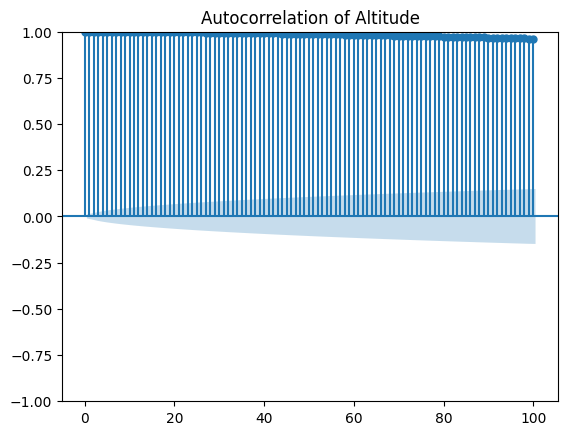

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10,5))
plot_acf(alt, lags=100)
plt.title("Autocorrelation of Altitude")
plt.show()

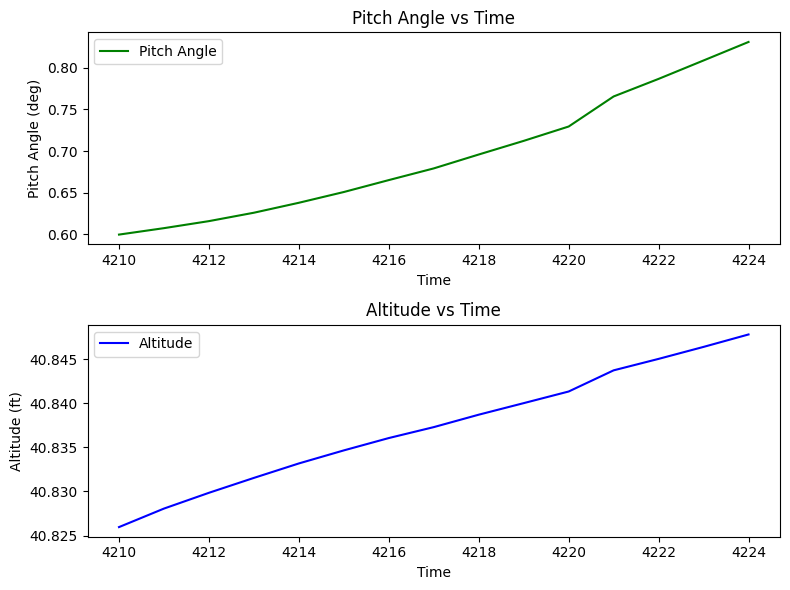

In [20]:
# visualize the data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
# pitch_deg - time plot
ax1.plot(df['x'][4210:4225], label='Pitch Angle', color='green')
ax1.set_xlabel('Time')
ax1.set_ylabel('Pitch Angle (deg)')
ax1.set_title('Pitch Angle vs Time')
ax1.legend()

# altitude_ft - time plot
ax2.plot(df['t'][4210:4225], label='Altitude', color='blue')
ax2.set_xlabel('Time')
ax2.set_ylabel('Altitude (ft)')
ax2.set_title('Altitude vs Time')
ax2.legend()

plt.tight_layout()
plt.show()

In [27]:
df = df.iloc[4210:].reset_index(drop=True)
print(df)

             x         t
0      0.59954  40.82596
1      0.60728  40.82806
2      0.61573  40.82985
3      0.62583  40.83154
4      0.63780  40.83318
...        ...       ...
29403  3.68583  33.79496
29404  3.50730  33.75129
29405  3.32268  33.70770
29406  3.15426  33.66908
29407  2.98599  33.63131

[29408 rows x 2 columns]


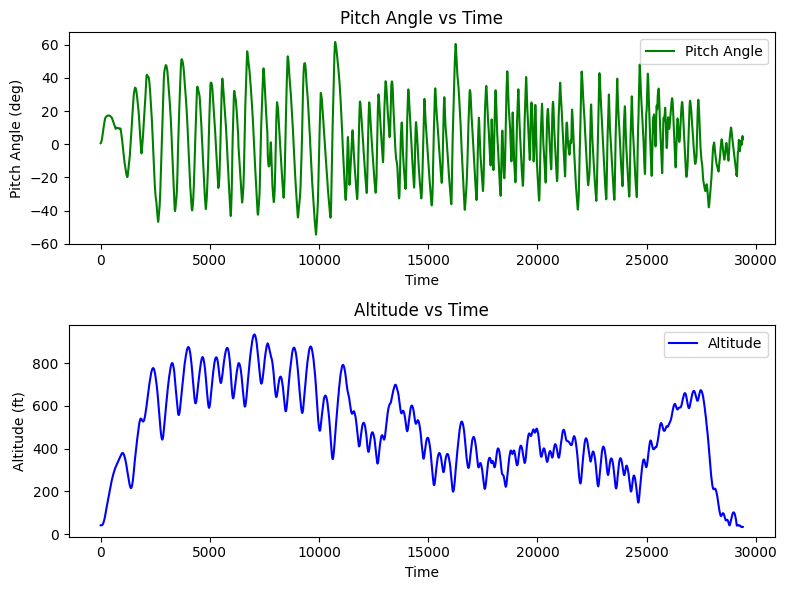

In [28]:
# visualize the data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
# pitch_deg - time plot
ax1.plot(df['x'], label='Pitch Angle', color='green')
ax1.set_xlabel('Time')
ax1.set_ylabel('Pitch Angle (deg)')
ax1.set_title('Pitch Angle vs Time')
ax1.legend()

# altitude_ft - time plot
ax2.plot(df['t'], label='Altitude', color='blue')
ax2.set_xlabel('Time')
ax2.set_ylabel('Altitude (ft)')
ax2.set_title('Altitude vs Time')
ax2.legend()

plt.tight_layout()
plt.show()

### Data Preprocessing

In [40]:
# Generate dataset from input output
df_lagged = pd.DataFrame({
    "x(t)"   : df["x"],
    "t(t-1)" : df["t"].shift(1),
    "t(t-2)" : df["t"].shift(2),
    "t(t-3)" : df["t"].shift(3),
    "t(t-4)" : df["t"].shift(4),
    "t(t)"   : df["t"]
})

df_lagged = df_lagged.dropna().reset_index(drop=True) # drop NaN values from first lagged rows

# Check the dataset
print(df_lagged.head())
print(df_lagged.shape)

# Separate input and output
X = df_lagged.drop(columns = "t(t)").values   # input size=6
T = df_lagged[["t(t)"]].values    # target

# check size input and output
print(X.shape, T.shape)

      x(t)    t(t-1)    t(t-2)    t(t-3)    t(t-4)      t(t)
0  0.63780  40.83154  40.82985  40.82806  40.82596  40.83318
1  0.65073  40.83318  40.83154  40.82985  40.82806  40.83466
2  0.66507  40.83466  40.83318  40.83154  40.82985  40.83606
3  0.67912  40.83606  40.83466  40.83318  40.83154  40.83730
4  0.69582  40.83730  40.83606  40.83466  40.83318  40.83871
(29404, 6)
(29404, 5) (29404, 1)


In [41]:
train_size = int(0.6 * X.shape[0])
val_size = int(0.2 * X.shape[0])
test_size = X.shape[0] - train_size - val_size

def split_dataset_seq(X, T):
    X_train = X[:train_size]
    T_train = T[:train_size]

    X_val = X[train_size:train_size+val_size]
    T_val = T[train_size:train_size+val_size]

    X_test = X[train_size+val_size:]
    T_test = T[train_size+val_size:]

    return X_train, T_train, X_val, T_val, X_test, T_test

X_train, T_train, X_val, T_val, X_test, T_test = split_dataset_seq(X, T)
print("Train:", X_train.shape, T_train.shape)
print("Val  :", X_val.shape, T_val.shape)
print("Test :", X_test.shape, T_test.shape)

Train: (17642, 5) (17642, 1)
Val  : (5880, 5) (5880, 1)
Test : (5882, 5) (5882, 1)


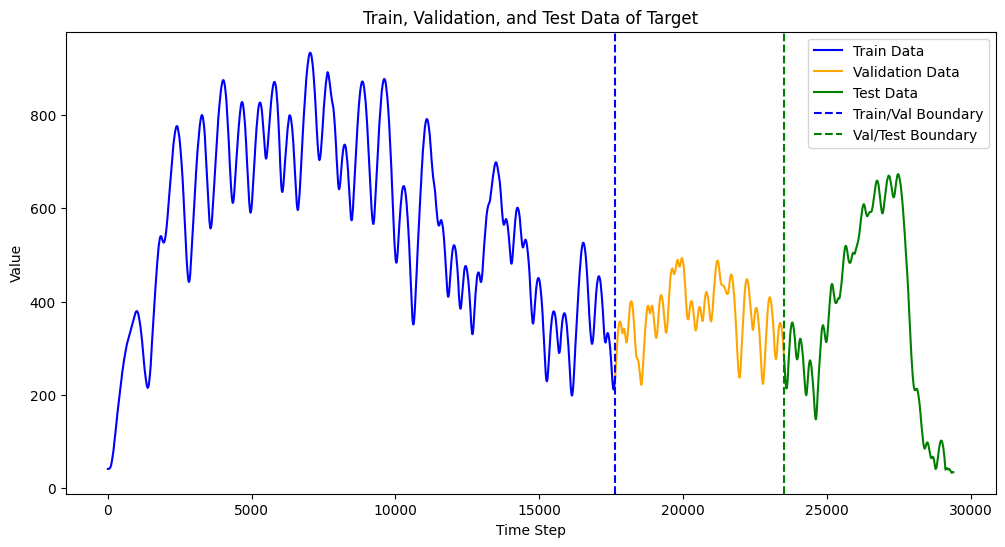

In [42]:
plt.figure(figsize=(12, 6))

# Plot each segment with its corresponding x range
plt.plot(range(0, train_size), T_train, label='Train Data', color='blue')
plt.plot(range(train_size, train_size+val_size), T_val, label='Validation Data', color='orange')
plt.plot(range(train_size+val_size, train_size+val_size+test_size), T_test, label='Test Data', color='green')

# Add vertical lines to indicate approximate boundaries
plt.axvline(x=train_size, color='b', linestyle='--', label='Train/Val Boundary')
plt.axvline(x=train_size+val_size, color='g', linestyle='--', label='Val/Test Boundary')

plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Train, Validation, and Test Data of Target")

plt.show()

In [46]:
# Standardize dataset
xscaler = StandardScaler()
X_train_norm = xscaler.fit_transform(X_train)
X_val_norm = xscaler.transform(X_val)
X_test_norm = xscaler.transform(X_test)

yscaler = StandardScaler()
T_train_norm = yscaler.fit_transform(T_train)
T_val_norm = yscaler.transform(T_val)
T_test_norm = yscaler.transform(T_test)

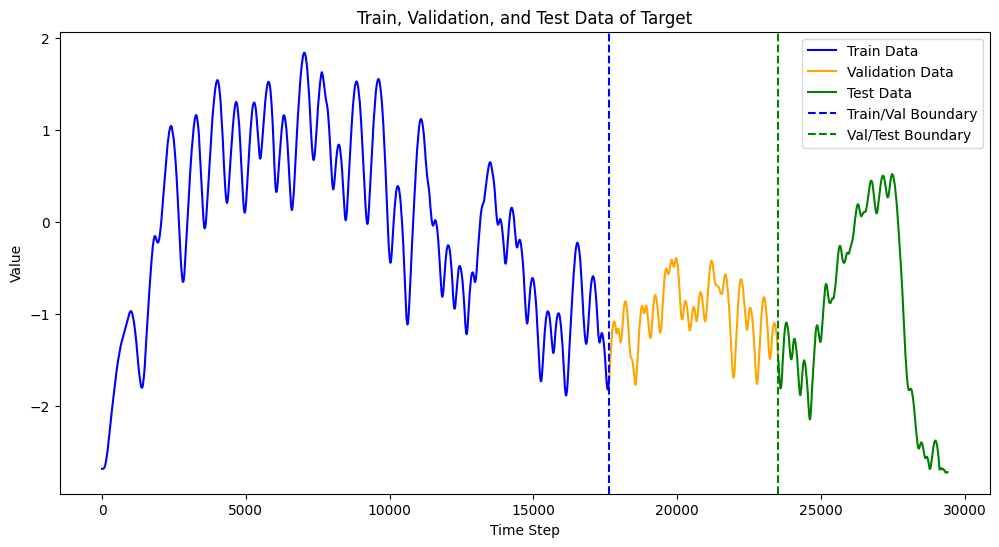

In [47]:
plt.figure(figsize=(12, 6))

# Plot each segment with its corresponding x range
plt.plot(range(0, train_size), T_train_norm, label='Train Data', color='blue')
plt.plot(range(train_size, train_size+val_size), T_val_norm, label='Validation Data', color='orange')
plt.plot(range(train_size+val_size, train_size+val_size+test_size), T_test_norm, label='Test Data', color='green')

# Add vertical lines to indicate approximate boundaries
plt.axvline(x=train_size, color='b', linestyle='--', label='Train/Val Boundary')
plt.axvline(x=train_size+val_size, color='g', linestyle='--', label='Val/Test Boundary')

plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Train, Validation, and Test Data of Target")

plt.show()

In [48]:
# Prepare to be processed with GPU
# This GPU uses float32
Xtrain = torch.tensor(X_train_norm, dtype=torch.float32).to(device)
Ttrain = torch.tensor(T_train_norm, dtype=torch.float32).to(device)
Xval = torch.tensor(X_val_norm, dtype=torch.float32).to(device)
Tval = torch.tensor(T_val_norm, dtype=torch.float32).to(device)
Xtest = torch.tensor(X_test_norm, dtype=torch.float32).to(device)
Ttest = torch.tensor(T_test_norm, dtype=torch.float32).to(device)

### MLP Model

In [55]:
input_dim = X_train.shape[1]
output_dim = T_train.shape[1]   # 1

class MLP(nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.fc1 = nn.Linear(input_dim, 32)
    self.fc2 = nn.Linear(32, 16)
    self.fc3 = nn.Linear(16, output_dim)
    self.tanh = nn.Tanh()
  def forward(self, x):
    x = self.tanh(self.fc1(x))
    x = self.tanh(self.fc2(x))
    x = self.fc3(x)
    return x

model = MLP(input_dim, output_dim).to(device)

### Training and Validation

In [56]:
# training setup
n_epochs = 100
optimizer = optim.Adam(model.parameters(), lr=1e-5)
loss_fn = nn.MSELoss()
# validation setup
patience = 10
tol = 1e-5

def train(model, optimizer, loss_fn, X_train, T_train, X_val, T_val,
          epochs=20, patience=10, tol=1e-5, device="cpu"):
    history = {"train_loss":[], "val_loss":[]}
    best_val_loss = float('inf')
    patience_ctr = 0
    for epoch in range(epochs):
        # === train ====
        model.train()
        train_loss = 0.0
        for i in range(len(X_train)):
            x = X_train[i]
            t = T_train[i]
            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, t)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(X_train)
        history["train_loss"].append(train_loss)

        # === validate ===
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i in range(len(X_val)):
                x = X_val[i]
                t = T_val[i]
                pred = model(x)
                loss = loss_fn(pred, t)
                val_loss += loss.item()
        val_loss /= len(X_val)
        history["val_loss"].append(val_loss)

        # === early stopping ===
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # best_model_weights = model.state_dict()  # simpan di memory
            # torch.save(model.state_dict(), 'best_model.pt')
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history' : history
            }, '/content/drive/MyDrive/Colab Notebooks/SBP, MML/ZSA_first_checkpoint.pt')
            patience_ctr = 0
        else:
            patience_ctr += 1

        if patience_ctr >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        if train_loss < tol:
            # best_model_weights = model.state_dict()  # simpan di memory
            # torch.save(model.state_dict(), 'best_model.pt')
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history' : history
            }, '/content/drive/MyDrive/Colab Notebooks/SBP, MML/ZSA_first_checkpoint.pt')
            print(f"Epoch {epoch}: train MSE {train_loss:.6f}, val MSE {val_loss:.6f}")
            break

        print(f"Epoch {epoch}: train MSE {train_loss:.6f}, val MSE {val_loss:.6f}")

    return history

history = train(model, optimizer, loss_fn, Xtrain, Ttrain, Xval, Tval, n_epochs, patience, tol, device)

Epoch 0: train MSE 0.114910, val MSE 0.036285
Epoch 1: train MSE 0.017734, val MSE 0.026464
Epoch 2: train MSE 0.010163, val MSE 0.019912
Epoch 3: train MSE 0.006340, val MSE 0.015268
Epoch 4: train MSE 0.004183, val MSE 0.011777
Epoch 5: train MSE 0.002858, val MSE 0.009056
Epoch 6: train MSE 0.002004, val MSE 0.006918
Epoch 7: train MSE 0.001436, val MSE 0.005251
Epoch 8: train MSE 0.001046, val MSE 0.003994
Epoch 9: train MSE 0.000773, val MSE 0.003075
Epoch 10: train MSE 0.000581, val MSE 0.002443
Epoch 11: train MSE 0.000443, val MSE 0.002028
Epoch 12: train MSE 0.000343, val MSE 0.001789
Epoch 13: train MSE 0.000271, val MSE 0.001661
Epoch 14: train MSE 0.000216, val MSE 0.001561
Epoch 15: train MSE 0.000174, val MSE 0.001446
Epoch 16: train MSE 0.000140, val MSE 0.001316
Epoch 17: train MSE 0.000114, val MSE 0.001184
Epoch 18: train MSE 0.000092, val MSE 0.001061
Epoch 19: train MSE 0.000074, val MSE 0.000953
Epoch 20: train MSE 0.000060, val MSE 0.000861
Epoch 21: train MSE 0.0

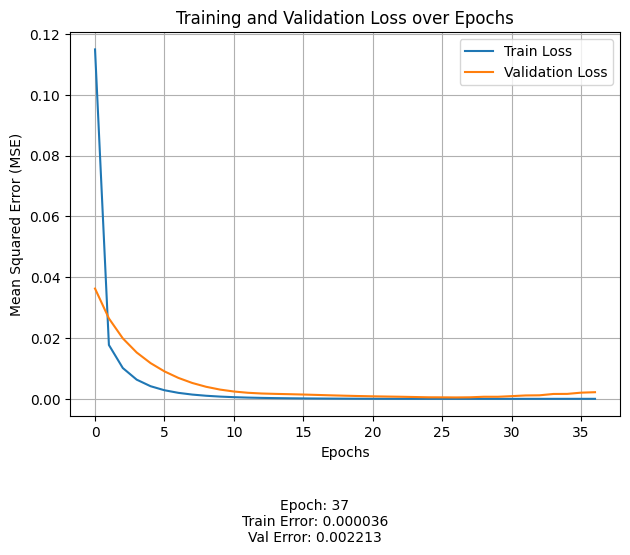

In [57]:
# Training validation loss plot
# get the data
train_losses = history["train_loss"]
val_losses = history["val_loss"]

last_epoch = len(train_losses)
train_error = train_losses[-1]
val_error = val_losses[-1]
annotation_text = f"Epoch: {last_epoch}\nTrain Error: {train_error:.6f}\nVal Error: {val_error:.6f}"

# plotting
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Training and Validation Loss over Epochs')
ax.grid(True)
ax.legend()
fig.text(0.5, -0.05, annotation_text, ha='center', va='top')

plt.tight_layout()
plt.show()

In [58]:
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/SBP, MML/ZSA_first_checkpoint.pt')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [64]:
# Predictions
model.eval()
pred = []
with torch.no_grad():
  for i in range(len(Xtest)):
    x = Xtest[i]
    y_pred = model(x)
    pred.append(y_pred.cpu().numpy())

pred = np.array(pred)   # numpy, (1000, 1), scaled
pred = yscaler.inverse_transform(pred)

print(f"type: {type(pred)}, dim: {pred.shape}")
print(f"type: {type(T_test)}, dim: {T_test.shape}")

print(pred)
print(T_test)

mse_test = np.mean((pred - T_test)**2)
print(f"mse test: {mse_test}")

type: <class 'numpy.ndarray'>, dim: (5882, 1)
type: <class 'numpy.ndarray'>, dim: (5882, 1)
[[279.0885 ]
 [278.05377]
 [276.89   ]
 ...
 [ 67.76834]
 [ 67.78317]
 [ 67.80237]]
[[271.53104]
 [270.47107]
 [269.44595]
 ...
 [ 33.7077 ]
 [ 33.66908]
 [ 33.63131]]
mse test: 187.70067251181408


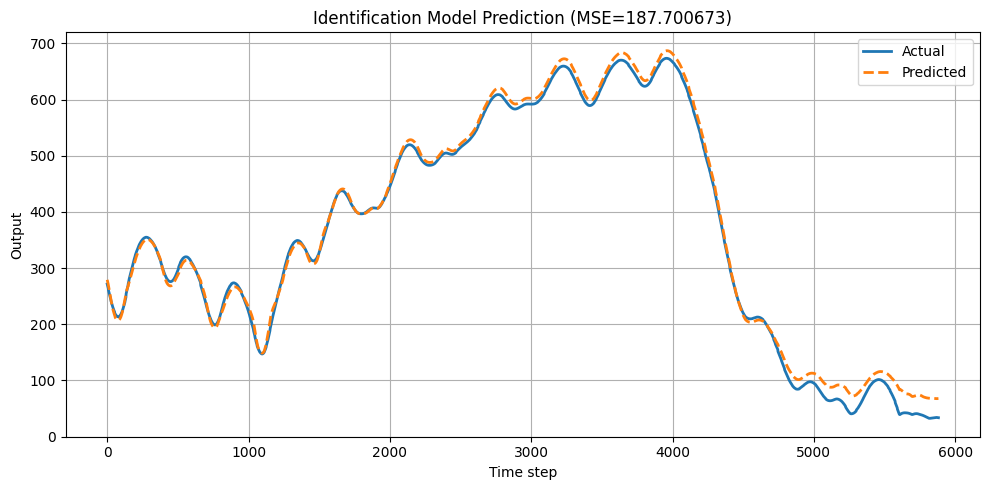

In [60]:
# Prediction vs target plot
plt.figure(figsize=(10, 5))
plt.plot(T_test, label='Actual', linewidth=2)
plt.plot(pred, label='Predicted', linestyle='--', linewidth=2)
plt.title(f'Identification Model Prediction (MSE={mse_test:.6f})')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Phase 2

### Data Preprocessing

In [65]:
# Generate dataset with lags
df_lagged = pd.DataFrame({
    "x(t)"   : df["x"],
    "t(t)"   : df["t"]
})

df_lagged = df_lagged.dropna().reset_index(drop=True)

# Check the dataset
print(df_lagged.head())
print(df_lagged.shape)

      x(t)      t(t)
0  0.59954  40.82596
1  0.60728  40.82806
2  0.61573  40.82985
3  0.62583  40.83154
4  0.63780  40.83318
(29408, 2)


In [66]:
# Separate input and output
X = df_lagged.drop(columns = 't(t)').values
T = df_lagged[["t(t)"]].values

# check size of dataset
print(X.shape, T.shape)

X_train, T_train, X_val, T_val, X_test, T_test = split_dataset_seq(X, T)
print("Train:", X_train.shape, T_train.shape)
print("Val  :", X_val.shape, T_val.shape)
print("Test :", X_test.shape, T_test.shape)

(29408, 1) (29408, 1)
Train: (17642, 1) (17642, 1)
Val  : (5880, 1) (5880, 1)
Test : (5886, 1) (5886, 1)


In [68]:
# Normalize dataset
xscaler = StandardScaler()
X_train_norm = xscaler.fit_transform(X_train)
X_val_norm = xscaler.transform(X_val)
X_test_norm = xscaler.transform(X_test)

yscaler = StandardScaler()
T_train_norm = yscaler.fit_transform(T_train)
T_val_norm = yscaler.transform(T_val)
T_test_norm = yscaler.transform(T_test)

In [69]:
# Prepare to be processed with GPU
# My GPU uses float32
Xtrain = torch.tensor(X_train_norm, dtype=torch.float32).to(device)
Ttrain = torch.tensor(T_train_norm, dtype=torch.float32).to(device)
Xval = torch.tensor(X_val_norm, dtype=torch.float32).to(device)
Tval = torch.tensor(T_val_norm, dtype=torch.float32).to(device)
Xtest = torch.tensor(X_test_norm, dtype=torch.float32).to(device)
Ttest = torch.tensor(T_test_norm, dtype=torch.float32).to(device)

### Training and validation

In [77]:
# narx setup
y_lags = 4
# load the same model
model = MLP(input_dim, output_dim).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
# training setup
n_epochs = 100
optimizer = optim.Adam(model.parameters())
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss_fn = nn.MSELoss()
# validation setup
patience = 10
tol = 1e-5

for param_group in optimizer.param_groups:
  # print(param_group['lr'])
  param_group['lr'] = 1e-4   # learning rate baru

In [78]:
def trainNARX(model, optimizer, loss_fn, X_train, T_train, X_val, T_val, y_lags,
          epochs=20, patience=10, tol=1e-5, device="cpu"):
    history = {"train_loss":[], "val_loss":[]}
    best_val_loss = float('inf')
    patience_ctr = 0
    for epoch in range(epochs):
    # for epoch in range(1):
        # === train ====
        model.train()
        train_loss = 0.0
        y_buffer = torch.zeros(y_lags, device = device)
        for i in range(len(X_train)):
            # print(f"sample: {i+1}")
            x = X_train[i]
            # print(f"x: {x}")
            t = T_train[i]
            # print(f"t:{t}")
            x_aug = torch.cat((x, y_buffer), dim=0)
            # print(f"x_aug: {x_aug}")
            optimizer.zero_grad()
            pred = model(x_aug)
            # print(f"pred: {pred}")
            loss = loss_fn(pred, t)
            loss.backward()
            optimizer.step()
            y_buffer = torch.cat([pred.detach(), y_buffer[:-1]])
            # print(f"y_buffer: {y_buffer}")
            train_loss += loss.item()
        train_loss /= len(X_train)
        history["train_loss"].append(train_loss)

        # === validate ===
        model.eval()
        val_loss = 0.0
        y_buffer = torch.zeros(y_lags, device = device)
        with torch.no_grad():
            for i in range(len(X_val)):
                x = X_val[i]
                t = T_val[i]
                x_aug = torch.cat((x, y_buffer), dim=0)
                pred = model(x_aug)
                loss = loss_fn(pred, t)
                y_buffer = torch.cat([pred.detach(), y_buffer[:-1]])
                val_loss += loss.item()
        val_loss /= len(X_val)
        history["val_loss"].append(val_loss)

        # === early stopping ===
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, '/content/drive/MyDrive/Colab Notebooks/SBP, MML/ZSA_second_checkpoint.pt')
            patience_ctr = 0
        else:
            patience_ctr += 1

        if patience_ctr >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if train_loss < tol:
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, '/content/drive/MyDrive/Colab Notebooks/SBP, MML/ZSA_second_checkpoint.pt')
            print(f"Epoch {epoch}: train MSE {train_loss:.6f}, val MSE {val_loss:.6f}")
            break

        print(f"Epoch {epoch}: train MSE {train_loss:.6f}, val MSE {val_loss:.6f}")

    return history

history = trainNARX(model, optimizer, loss_fn, Xtrain, Ttrain, Xval, Tval, y_lags, n_epochs, patience, tol, device)

Epoch 0: train MSE 0.150720, val MSE 1.964368
Epoch 1: train MSE 0.183728, val MSE 1.566714
Epoch 2: train MSE 0.192651, val MSE 1.428322
Epoch 3: train MSE 0.197195, val MSE 1.098219
Epoch 4: train MSE 0.199452, val MSE 0.858278
Epoch 5: train MSE 0.197017, val MSE 0.726191
Epoch 6: train MSE 0.200168, val MSE 0.676534
Epoch 7: train MSE 0.203107, val MSE 0.645496
Epoch 8: train MSE 0.206336, val MSE 0.608534
Epoch 9: train MSE 0.202439, val MSE 0.561317
Epoch 10: train MSE 0.194185, val MSE 0.589428
Epoch 11: train MSE 0.202630, val MSE 0.533712
Epoch 12: train MSE 0.199092, val MSE 0.479903
Epoch 13: train MSE 0.205249, val MSE 0.470694
Epoch 14: train MSE 0.209342, val MSE 0.488758
Epoch 15: train MSE 0.218121, val MSE 0.458212
Epoch 16: train MSE 0.209943, val MSE 0.604379
Epoch 17: train MSE 0.172433, val MSE 0.724643
Epoch 18: train MSE 0.160423, val MSE 0.778872
Epoch 19: train MSE 0.163751, val MSE 0.721321
Epoch 20: train MSE 0.158199, val MSE 0.699314
Epoch 21: train MSE 0.1

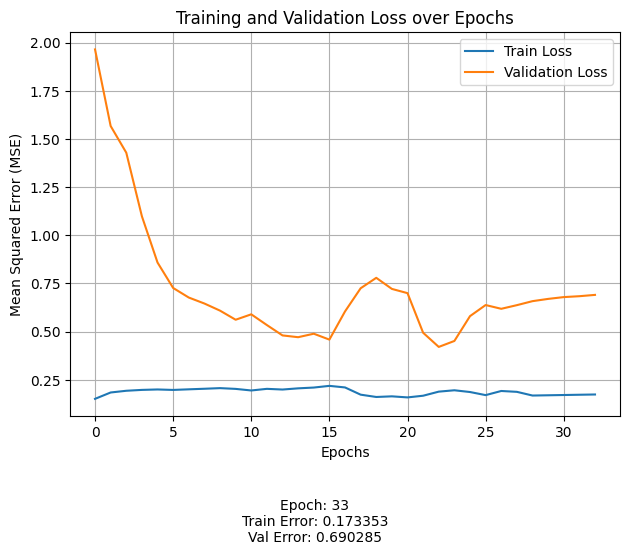

In [79]:
# training validation loss plot
# get the data
train_losses = history["train_loss"]
val_losses = history["val_loss"]
last_epoch = len(train_losses)
train_error = train_losses[-1]
val_error = val_losses[-1]
annotation_text = f"Epoch: {last_epoch}\nTrain Error: {train_error:.6f}\nVal Error: {val_error:.6f}"

# plotting
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Training and Validation Loss over Epochs')
ax.grid(True)
ax.legend()
fig.text(0.5, -0.05, annotation_text, ha='center', va='top')

plt.tight_layout()
plt.show()

In [81]:
# Predictions
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/SBP, MML/ZSA_second_checkpoint.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
y_lags = 4
pred = []
y_buffer = torch.zeros(y_lags, device = device) # y_buffer = [0, 0]
with torch.no_grad():
    for i in range(len(Xtest)):
        x = Xtest[i]
        x_aug = torch.cat((x, y_buffer), dim=0)
        y_pred = model(x_aug)
        y_buffer = torch.cat([y_pred.detach(), y_buffer[1:]])
        pred.append(y_pred.cpu().numpy())

pred = np.array(pred)   # numpy, (1000, 1), scaled
pred = yscaler.inverse_transform(pred)

print(f"type: {type(pred)}, dim: {pred.shape}")
print(f"type: {type(T_test)}, dim: {T_test.shape}")

print(pred)
print(T_test)

mse_test = np.mean((pred - T_test)**2)
print(f"mse test: {mse_test}")

type: <class 'numpy.ndarray'>, dim: (5886, 1)
type: <class 'numpy.ndarray'>, dim: (5886, 1)
[[356.13907]
 [221.42017]
 [206.19116]
 ...
 [281.9305 ]
 [281.90985]
 [281.88904]]
[[275.9581 ]
 [274.87894]
 [273.90414]
 ...
 [ 33.7077 ]
 [ 33.66908]
 [ 33.63131]]
mse test: 50450.88929822644


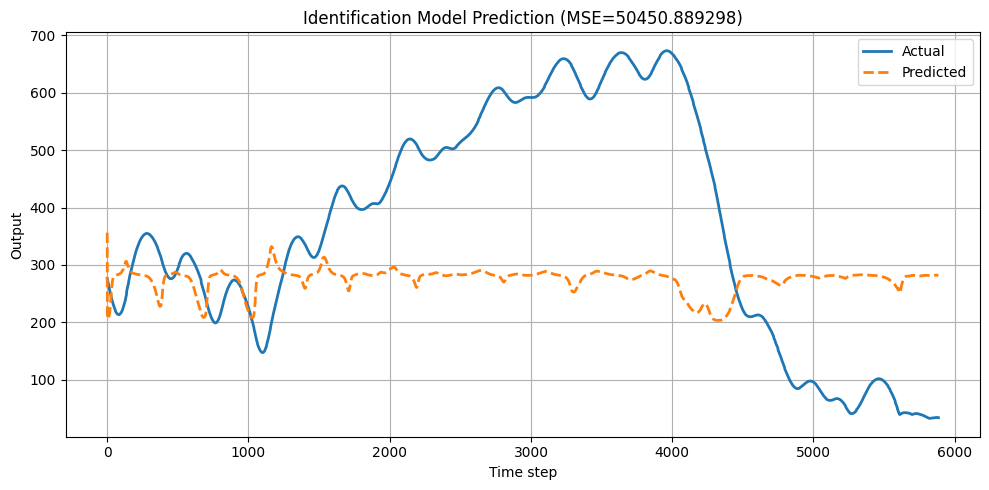

In [82]:
# Prediction vs target plot
plt.figure(figsize=(10, 5))
plt.plot(T_test, label='Actual', linewidth=2)
plt.plot(pred, label='Predicted', linestyle='--', linewidth=2)
plt.title(f'Identification Model Prediction (MSE={mse_test:.6f})')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()